# Sparse Linear Inverse Demo with AMP

In this demo, we illustrate how to use the `vampyre` package for a simple sparse linear inverse problem.   The problem is to estimate a sparse vector `z0` from linear measurements of the form `y=A.dot(z0)+w` where `w` is Gaussian noise and `A` is a known linear transform -- a basic problem in compressed sensing.  By *sparse*, we mean that the vector `z0` has few non-zero values.  Knowing that the vector is sparse can be used for improved reconstruction if an appropriate sparse reconstruction algorithm is used.

There are a large number of algorithms for sparse linear inverse problems.  This demo uses the Generalized Approximate Message Passing (GAMP) method, one of several methods that will be included in the `vampyre` package.  In going through this demo, you will learn to:
* Load the `vampyre` package
* Create synthetic data for a sparse linear inverse problem
* Set up the GAMP method in the `vampyre` package to perform the estimation for the linear inverse problem
* Measure the mean squared error (MSE) and compare the value to the predicted value from the VAMP method.
* Using the `hist_list` feature to track variables per iteration of the algorithm.
* Adjust the damping factor for ill-conditioned matrices.

An almost identical [demo](./sparse_lin_inverse.ipynb) is available for the Vector AMP (VAMP) method.  The VAMP method is more robust and similar to use.  You can start on that demo instead.

## Importing the Package 


First we need to import the `vampyre` package.  Since `python` does not have relative imports, you need to add the path location for the `vampyre` package to the system path.  In this case, we have specified the path use a relative path location, but you can change this depending on where `vampyre` is located.  

If you have not installed the package [Tensorflow](https://www.tensorflow.org/install/), you will get a warning.  The warning can be ignored as the package is needed only if you use Tensorflow-based estimators in AMP.

In [1]:
import os
import sys
vp_path = os.path.abspath('../../')
if not vp_path in sys.path:
    sys.path.append(vp_path)
import vampyre as vp

We will also load the other packages we will use in this demo.  This could be done before the above import.

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Generating Synthetic Data

We begin by generating synthetic data.  The model is:

    y = z1 + w,   z1 = A.dot(z0)
    
where `z0` and `z1` are the unknown vectors, `A` is transform and `w` is noise.  First, we set the dimensions and the shapes of the vectors we wil use.

In [3]:
# Parameters
nz0 = 1024   # number of components of z0
nz1 = 512    # number of measurements z1

# Compute the shapes
zshape0 = (nz0,)   # Shape of z0 matrix
zshape1 = (nz1,)   # Shape of z1 matrix = shape of y matrix
Ashape = (nz1,nz0)   # Shape of A matrix

To generate the synthetic data for this demo, we use the following simple probabilistic model.  For the input `z0`, we will use Bernouli-Gaussian (BG) distribution, a simple  model in sparse signal processing.  In the BG model, the components `z0[j]` are i.i.d. where each component can be *on* or *off*.   

*  With probability `prob_on`, `z0[i]` is *on* with `z0[i] ~ N(z0_mean_on,z0_var_on)`
*  With probability `1-prob_on`, `z0[i]` is *off* with `z0[i]=0`.

Thus, on average, on `prob_on*nz0` are *on$.  We set the parameters for the model as well as the SNR for the measurements.

In [4]:
prob_on = 0.1      # fraction of components that are *on*
z0_mean_on = 0     # mean for the on components
z0_var_on = 1      # variance for the on components
snr = 20           # SNR in dB

Using these parameters, we can generate random sparse `z0` following this distribution with the following simple code.

In [5]:
# Generate the random input 
z0_on = np.random.normal(z0_mean_on, np.sqrt(z0_var_on), zshape0)
u = np.random.uniform(0, 1, zshape0) < prob_on
z0 = z0_on*u

To illustrate the sparsity, we plot the vector `z0`.  We can see from this plot that the majority of the components of `z0` are zero.

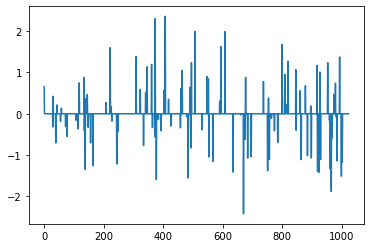

In [6]:
ind = np.array(range(nz0))
plt.plot(ind,z0)

Now, we create a random transform `A` and output `z1 = A.dot(z0)`

In [7]:
A = np.random.normal(0, 1/np.sqrt(nz0), Ashape)
z1 = A.dot(z0)

Finally, we add noise at the desired SNR

In [8]:
zvar1 = np.mean(np.abs(z1)**2)
wvar = zvar1*np.power(10, -0.1*snr)
w = np.random.normal(0,np.sqrt(wvar), zshape1)
y = z1 + w

## Setting up the AMP / GAMP Solver

Now that we have created the sparse data, we will use the `vampyre` package to recover `z0` and `z1` from `y`.  In `vampyre` the methods to perform this estimation are called *solvers*.  The basic Approximate Message Passing (AMP) algorithm was developed in:

*  Donoho, David L., Arian Maleki, and Andrea Montanari. "Message-passing algorithms for compressed sensing." Proceedings of the National Academy of Sciences 106.45 (2009): 18914-18919.

The `vampyre` package currently implements a slightly more general solver, called Generalized AMP described in:

* Rangan, Sundeep. "Generalized approximate message passing for estimation with random linear mixing." Proc. IEEE Internation Symposium on Information Theory (ISIT), 2011.

GAMP can handle nonlinear output channels.  In this demo, we will restrict our attention to the linear Gaussian channel, so the GAMP solver essentially implements the AMP algorithm.

Similar to most of the solvers in the `vampyre` package, the GAMP solver needs precise specifications of the probability distributions of `z0`, `z1` and `y`.  For the linear inverse problem, we will specify three components:
* The prior `p(z0)`; 
* The transform `A` such that `z1 = A.dot(z_0)`
* The likelihood `p(y|z1)`.


Both the prior and likelihood are described by *estimators*.   The transform is described by an *operator*.

We first describe the estimator for the prior `p(z0)`.  The `vampyre` package will eventually have a large number of estimators to describe various densities.  In this simple demo, `p(z0)` is what is called a *mixture* distribution since `z0` is one distribution with probability `1-prob_on` and a second distribution with probability `prob_on`.  To describe this mixture distribution in the `vampyre` package, we need to first create estimator classes for each component distribution.  To this end, the following code creates two estimators:
* `est0_off`:  The estimator corresponding to the `z0[j]=0`.  This is simply a discrete distribution with a point mass at zero.
* `est0_on`:  The estimator corresponding to the case when `z0[j] = N(z0_mean_on, z0_var_on)`.  This is a Gaussian distribution

In [9]:
est0_off = vp.estim.DiscreteEst(0,1,zshape0)
est0_on   = vp.estim.GaussEst(z0_mean_on, z0_var_on,zshape0)

We next use the `vampyre` class, `MixEst`, to describe a mixture of the two distributions.  This is done by creating a list, `est_list`, of the estimators and an array `pz` with the probability of each component.  The resulting estimator, `est_in`, is the estimator for the prior $z$, which is also the input to the transform $A$.  We give this a name `Input` since it corresponds to the input.  But, any naming is fine.  Or, you can let `vampyre` give it a generic name.

In [10]:
est_list = [est0_off, est0_on]
pz0 = np.array([1-prob_on, prob_on])
est0 = vp.estim.MixEst(est_list, w=pz0, name='Input')

We next define the operator `A`.  In thsi case the operator is defined by a matrix so we use the `MatrixLT` class.

In [11]:
Aop = vp.trans.MatrixLT(A,zshape0)

Finally, we describe the likelihood function, `p(y|z1)`.  Since `y=z1+w`, we can describe this as a Gaussian estimator.

In [12]:
est1  = vp.estim.GaussEst(y,wvar,zshape1,name='Output')

## Running the GAMP Solver

Having described the input and output estimators and the variance handler, we can now construct a GAMP solver.   The construtor takes the input and output estimators, the variance handler and other parameters. The paramter `nit` is the number of iterations.  This is fixed for now.  Later, we will add auto-termination.  The other parameter, `hist_list` is optional, and will be described momentarily.  

In [13]:
nit = 20  # number of iterations
solver = vp.solver.Gamp(est0,est1,Aop,hist_list=['z0', 'zvar0'],nit=nit)

We can print a summary of the model which indicates the dimensions and the estimators.

In [14]:
solver.summary()

est0: Input (Mixture) shape: (1024,)
est1: Output (GaussEst) shape: (512,)


We now run the solver by calling the `solve()` method.  For a small problem like this, this should be close to instantaneous.  

In [15]:
solver.solve()

The VAMP solver estimate is the field `zhat`.  We plot one column of this (`icol=0`) and compare it to the corresponding column of the true matrix `z`.  You should see a very good match.

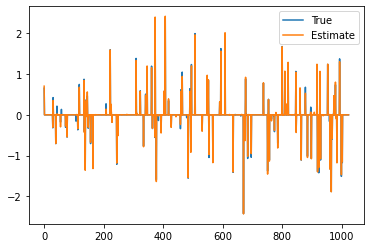

In [16]:
zhat0 = solver.z0
ind = np.array(range(nz0))
plt.plot(ind,z0)
plt.plot(ind,zhat0)
plt.legend(['True', 'Estimate'])

We can measure the normalized mean squared error as follows.  The GAMP solver also produces an estimate of the MSE in the variable `zvar0`.  We can extract this variable to compute the predicted MSE.  We see that the normalized MSE is indeed low and closely matches the predicted value from VAMP.

In [17]:
zerr0_act = np.mean(np.abs(zhat0-z0)**2)
zerr0_pred = solver.zvar0
zpow0 = np.mean(np.abs(z0)**2)
mse_act = 10*np.log10(zerr0_act/zpow0)
mse_pred = 10*np.log10(zerr0_pred/zpow0)
print("Normalized MSE (dB): actual {0:f} pred {1:f}".format(mse_act, mse_pred))

Normalized MSE (dB): actual -23.432660 pred -23.765066


Finally, we can plot the actual and predicted MSE as a function of the iteration number.  When `solver` was contructed, we passed an argument `hist_list=['z0', 'zvar0']`.  This indicated to store the value of the estimate `z0` and predicted error variance `zvar0` with each iteration.  We can recover these values from `solver.hist_dict`, the history dictionary.  Using the values we can compute and plot the normalized MSE on each iteartion.  Since we are going to plot several times in this demo, we wrap the plotting routine in a function, `plot_z0est()`. 

When we run `plot_z0est()` we see that GAMP gets a low MSE in very few iterations, about 10.

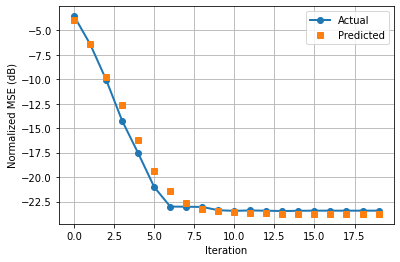

In [18]:
def plot_z0_est(solver,z0):
    """
    Plots the true and predicted MSE for the estimates of z0
    """
    # Compute the MSE as a function of the iteration
    zhat0_hist = solver.hist_dict['z0']
    zvar0_hist = solver.hist_dict['zvar0']
    nit = len(zhat0_hist)
    mse_act = np.zeros(nit)
    mse_pred = np.zeros(nit)
    for it in range(nit):
        zerr0_act = np.mean(np.abs(zhat0_hist[it]-z0)**2)
        zerr0_pred = zvar0_hist[it]    
        mse_act[it] = 10*np.log10(zerr0_act/zpow0)
        mse_pred[it] = 10*np.log10(zerr0_pred/zpow0)

    plt.plot(range(nit), mse_act, 'o-', linewidth=2)
    plt.plot(range(nit), mse_pred, 's', linewidth=1)
    plt.xlabel('Iteration')
    plt.ylabel('Normalized MSE (dB)')
    plt.legend(['Actual', 'Predicted'])
    plt.grid()
        
plot_z0_est(solver,z0)    

## Damping and Stability

A significant problem with GAMP is its stability.  GAMP and AMP are designed for Gaussian i.i.d. matrices.  For other matrices, the algorithms can diverge.  This divergence issue is one of the main difficulties in using GAMP and AMP in practivce.  

Recent research has shown that the convergence appears to be related to condition number of the matrix.  Matrices `A` with higher condition numbers tend to cause GAMP / AMP to diverge.  See, for example:
* Rangan, Sundeep, Philip Schniter, and Alyson Fletcher. "On the convergence of approximate message passing with arbitrary matrices." Proc. IEEE International Symposium on Information Theory (ISIT), 2014.

To illustrate we create a random matrix with a specified condition number.  This can be done with the `rand_rot_invariant` command.  Specifically, it creates a matrix `A=USV.T` where `U` and `V` are random orthogonal matrices and `S` has a specified condition number.

In [19]:
# Generate a random transform
A = vp.trans.rand_rot_invariant_mat(nz1,nz0,cond_num=10)
Aop = vp.trans.MatrixLT(A,zshape0)
z1 = A.dot(z0)

Now, we create a synthetic data based on the matrix and re-run GAMP.

In [20]:

# Add noise
zvar1 = np.mean(np.abs(z1)**2)
wvar = zvar1*np.power(10, -0.1*snr)
w = np.random.normal(0,np.sqrt(wvar), zshape1)
y = z1 + w

# Create the estimator
est1  = vp.estim.GaussEst(y,wvar,zshape1,name='Output')

# Run GAMP
nit = 20
solver = vp.solver.Gamp(est0,est1,Aop,hist_list=['z0', 'zvar0'],nit=nit)
solver.solve()

We plot the results and we can see that the algorithm diverges.

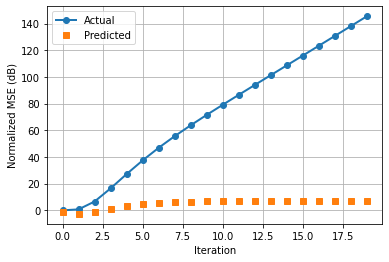

In [21]:
plot_z0_est(solver,z0)

To fix the problem, one can apply *damping*.  In damping, the GAMP algorithm is adjusted to take a *partial* step as controlled by a parameter `step` between 0 and 1.  In general, the theory is that `step <= 1/sqrt(cond_num)`.  In practice, you can try different step sizes until you get reasonable results.  A warning though:  Sometimes you never get great results.  

In this case, we take `step=0.3`.  We also need to run the algorithm for many more iterations.  We see we get better results although we have to run for more iterations.

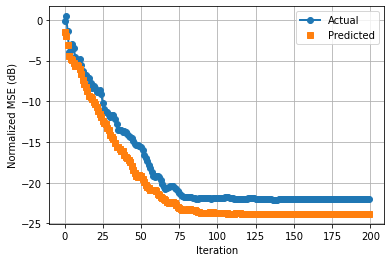

In [22]:
# Run GAMP with damping
nit = 200
solver = vp.solver.Gamp(est0,est1,Aop,hist_list=['z0', 'zvar0'],nit=nit,step=0.3)
solver.solve()

# Plot the results
plot_z0_est(solver,z0) 